In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE  # Add this import
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [4]:
df = pd.read_csv('DRG.csv')
df.head()

,Label,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,MaxEStateIndex,...,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,COC(=O)N(C)c1c(N)nc(nc1N)c2nn(Cc3ccccc3F)c4ncc...,1.821,1266.407,22.121,16.781,16.781,14.901,9.203,9.203,6.668,6.668,4.719,4.719,3.241,3.241,6.093,9.185,0.0,35.509,22.291,4.900,20.224,41.210,0.000,24.787,11.467,422.162,0.150,-4.28,31,403.272,1.218475e+07,20.012,7.859,3.564,175.833,14.164,0.452,14.164,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,C[C@H](N(O)C(=O)N)c1cc2ccccc2s1,2.363,490.434,11.707,8.752,9.569,7.592,4.854,5.670,3.545,4.661,2.449,3.735,1.520,2.621,12.073,10.002,0.0,0.000,5.063,14.963,0.000,18.261,30.332,0.000,5.734,236.062,0.182,-1.59,16,224.200,5.774616e+03,10.912,4.112,1.868,96.858,10.832,0.350,10.832,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
2,0,C[N+](C)(C)CC(=O)[O-],3.551,93.092,6.784,5.471,5.471,3.417,2.420,2.420,2.820,2.820,0.603,0.603,0.387,0.387,5.969,9.901,0.0,6.545,4.483,0.000,0.000,21.143,0.000,0.000,0.000,117.079,0.800,-0.57,8,106.060,2.300500e+01,7.430,2.132,5.430,49.125,9.888,0.544,9.888,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,CC(C)n1c(\C=C\[C@H](O)C[C@H](O)CC(=O)O)c(c2ccc...,2.076,1053.003,21.836,16.995,16.995,14.274,9.926,9.926,7.662,7.662,4.998,4.998,3.768,3.768,24.598,19.398,0.0,18.280,0.000,27.724,12.133,24.285,24.265,18.415,5.107,411.185,0.292,-2.96,30,385.265,4.553841e+06,21.742,9.238,4.777,174.259,13.498,0.481,13.498,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,C\C(=C(\C#N)/C(=O)Nc1ccc(cc1)C(F)(F)F)\O,2.888,549.823,14.629,9.746,9.746,8.752,5.040,5.040,3.601,3.601,2.171,2.171,1.232,1.232,28.979,17.966,0.0,5.687,0.000,31.189,6.069,0.000,0.000,5.317,10.368,270.062,0.167,-2.49,19,261.138,1.013411e+04,14.571,5.436,3.741,106.326,12.300,0.511,12.300,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Preparing features and target variable

In [5]:
# Separate features and target
# The 'Label' column is our target variable based on the CSV structure
X = df.drop('Label', axis=1)  # Features
y = df['Label']  # Target variable

# Remove SMILES column as it's not numerical
X = X.drop('SMILES', axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Print class distribution before and after SMOTE
print("Original class distribution:")
print(pd.Series(y_train).value_counts())
print("\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())

Original class distribution:
Label
0    290
1     91
Name: count, dtype: int64

Balanced class distribution:
Label
0    290
1    290
Name: count, dtype: int64


Train and evaluate multiple models:

In [6]:
# Create base models with optimized parameters
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Create voting classifier
voting_ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('gb', gb_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)

# Create pipeline with feature selection
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
    ('classifier', voting_ensemble)
])

# Update parameter grid to include XGBoost
param_grid = {
    'classifier__rf__n_estimators': [100, 200, 300],
    'classifier__rf__max_depth': [10, 20, None],
    'classifier__gb__n_estimators': [100, 200],
    'classifier__gb__learning_rate': [0.05, 0.1],
    'classifier__xgb__n_estimators': [100, 200],
    'classifier__xgb__learning_rate': [0.05, 0.1],
    'classifier__xgb__max_depth': [3, 5, 7]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)

# Fit grid search
grid_search.fit(X_train_balanced, y_train_balanced)

# Get selected features
feature_selector = grid_search.best_estimator_.named_steps['feature_selection']
X_test_selected = feature_selector.transform(X_test_scaled)

# Make predictions using the full pipeline
ensemble_pred = grid_search.predict(X_test_scaled)

# Individual model predictions (using selected features)
rf_pred = grid_search.best_estimator_.named_steps['classifier'].estimators_[0].predict(X_test_selected)
gb_pred = grid_search.best_estimator_.named_steps['classifier'].estimators_[1].predict(X_test_selected)
xgb_pred = grid_search.best_estimator_.named_steps['classifier'].estimators_[2].predict(X_test_selected)

# Print results
print("\nModel Performance Comparison:")
print("\nEnsemble Model:")
print(classification_report(y_test, ensemble_pred))
print("\nRandom Forest:")
print(classification_report(y_test, rf_pred))
print("\nGradient Boosting:")
print(classification_report(y_test, gb_pred))
print("\nXGBoost:")
print(classification_report(y_test, xgb_pred))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [10:11:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Model Performance Comparison:

Ensemble Model:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        69
           1       0.61      0.41      0.49        27

    accuracy                           0.76        96
   macro avg       0.70      0.65      0.67        96
weighted avg       0.74      0.76      0.74        96


Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.96      0.86        69
           1       0.75      0.33      0.46        27

    accuracy                           0.78        96
   macro avg       0.77      0.64      0.66        96
weighted avg       0.78      0.78      0.75        96


Gradient Boosting:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84        69
           1       0.59      0.37      0.45        27

    accuracy                           0.75        96
   macro avg       0.69      0.63      0.65 

Vizualization

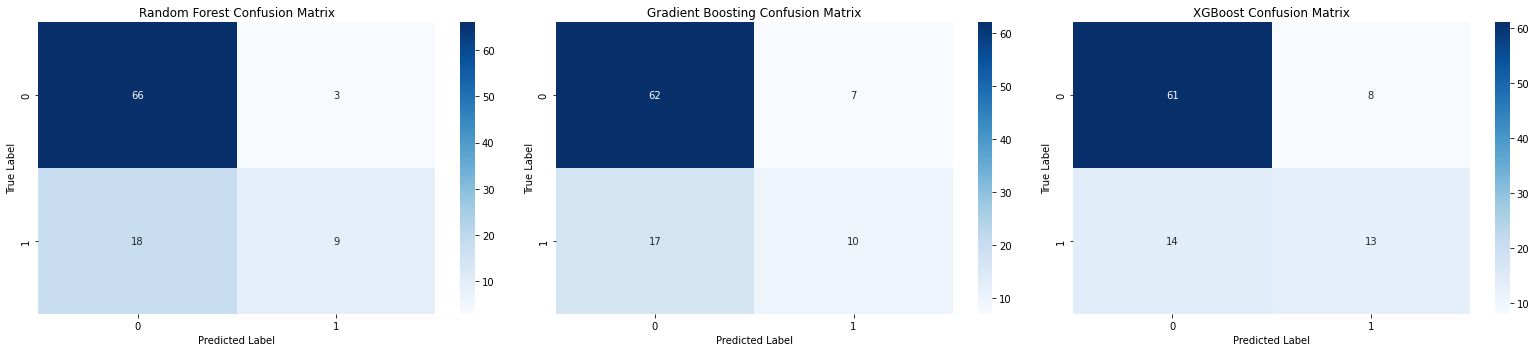

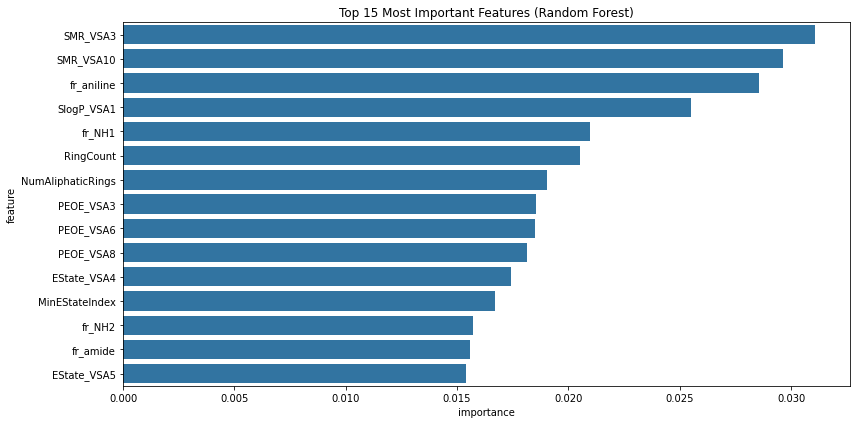

In [7]:
# Plot confusion matrices
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5))

sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Random Forest Confusion Matrix')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

sns.heatmap(confusion_matrix(y_test, gb_pred), annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Gradient Boosting Confusion Matrix')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_title('XGBoost Confusion Matrix')
ax3.set_ylabel('True Label')
ax3.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Get selected feature names and importance scores
feature_selector = grid_search.best_estimator_.named_steps['feature_selection']
selected_features_mask = feature_selector.get_support()
selected_features = X.columns[selected_features_mask]

# Create feature importance DataFrame for selected features only
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': grid_search.best_estimator_.named_steps['classifier'].estimators_[0].feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

ROC Curve

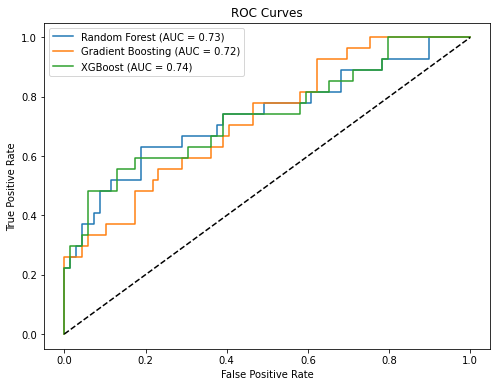

In [8]:
# Calculate ROC curves
rf_proba = grid_search.best_estimator_.named_steps['classifier'].estimators_[0].predict_proba(X_test_selected)[:, 1]
gb_proba = grid_search.best_estimator_.named_steps['classifier'].estimators_[1].predict_proba(X_test_selected)[:, 1]
xgb_proba = grid_search.best_estimator_.named_steps['classifier'].estimators_[2].predict_proba(X_test_selected)[:, 1]

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_proba)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_proba)

rf_auc = auc(rf_fpr, rf_tpr)
gb_auc = auc(gb_fpr, gb_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(gb_fpr, gb_tpr, label=f'Gradient Boosting (AUC = {gb_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()